In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import pandas as pd

from banditfriday.simulation import simulate
from banditfriday.datagen import generate_product_data
from banditfriday.products import plot_product_probabilities, plot_max_probabilities, ALL_PRODUCTS
from banditfriday.strategies.baseline_strategy import BaselineStrategy
from banditfriday.strategies.binned_strategy import BinnedStrategy
from banditfriday.strategies.thompson_strategy import ThompsonSampling
from banditfriday.strategies.cheating_strategy import CheatingStrategy

# Super simple contextual bandit 

This is a result of a Friday hackaton. This notebook shows how we built the simplest contextual bandit we could think of.

The outline of this notebook is as follows:
- Goal
- Use Case / Setting
- Generated Data
- Strategies
- Simulation
- Results

## Goal
We set out to explore contextual bandits. Our aim was to build the simplest version of a contextual bandit. 

## Use Case / Setting

- We recommend products to customers 
- The buying/click probability for each customer for each product depends on age and wealth (this is the **context** that the contextual bandit should learn)


## Generated Data

We generated data as follows:
    
- We created a set of products with buying/click probabilities conditional on age and wealth
    - We tried to come up with differently shaped distributions (also see below)
- We generated records by:
    - Randomly sampling age and wealth
    - Sampling buy/click behaviour (yes or no) based on the earlier defined conditional probabilties

So each record represents how a customer would react to each of the products.

In [61]:
# NOTE: age and wealth are normalized to the range 0-1
training_data = generate_product_data()
training_data.head()

,id,age,wealth,Beer,CheapToiletPaper,Diapers,Lollipops,Raspberries,Potatoes,Sushi
0,0,0.741391,0.805647,True,False,False,False,True,False,True
1,1,0.981500,0.396778,True,False,False,False,False,True,False
2,2,0.056571,0.510454,False,False,False,False,False,False,False
3,3,0.224675,0.909156,False,False,True,True,False,False,True
4,4,0.712277,0.936888,False,False,False,False,True,False,False


Below you see the buying probability for each of our products based on age and wealth (normalized as you see on the axis). 

E.g. Raspberries are more likely to be bought by old and wealthy people. And sushi by wealthy young-adults.

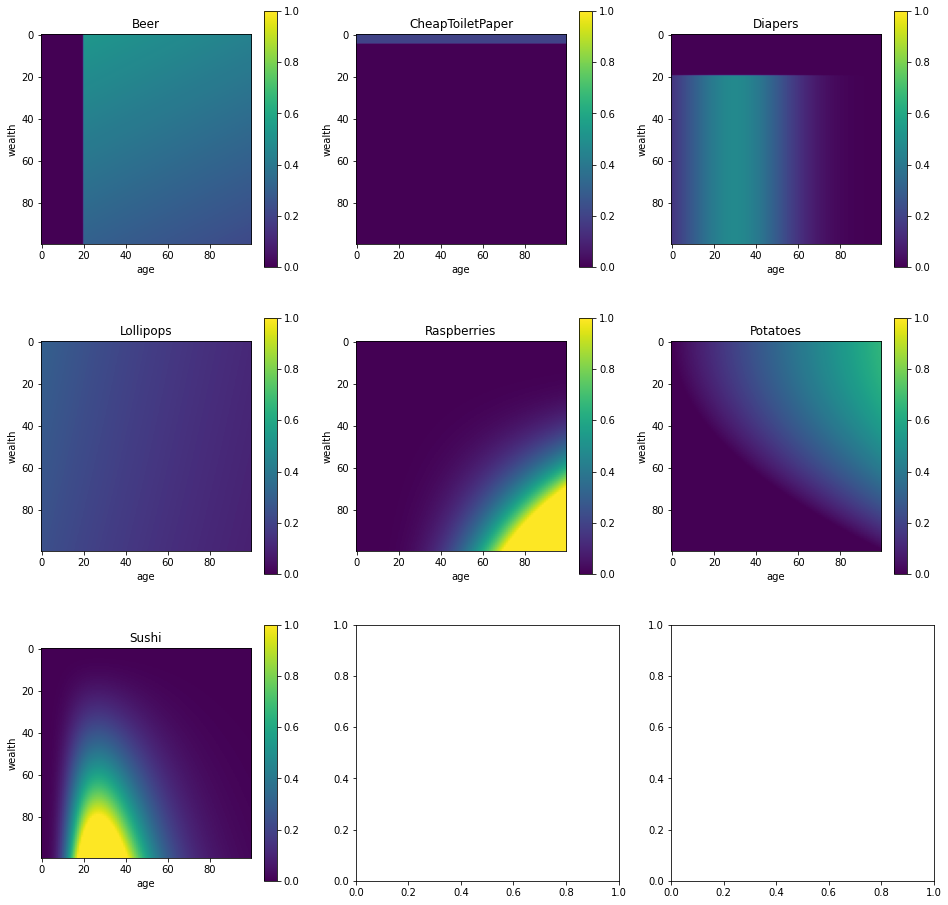

In [29]:
plot_product_probabilities(ALL_PRODUCTS)

Just for fun; the plot below shows for each context (combination of age and wealth) which product is most popular.

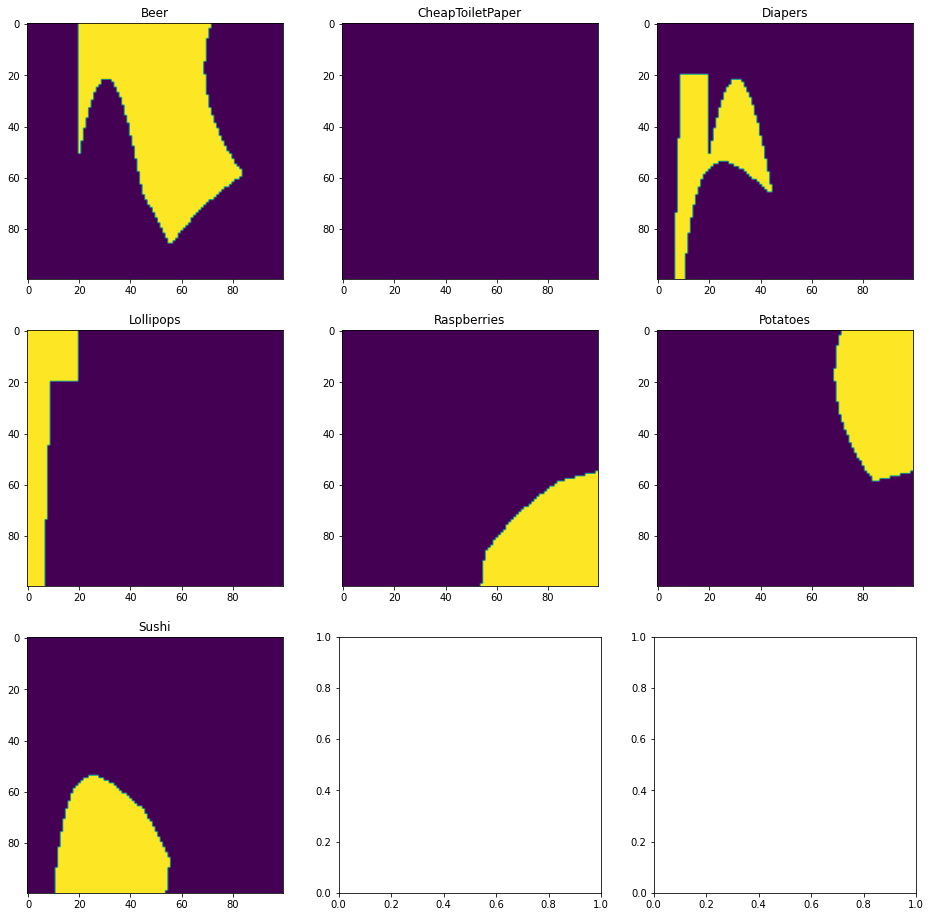

In [52]:
plot_max_probabilities(ALL_PRODUCTS)

## Strategies

### Baseline recommender
The baseline recommender learns from historic data the overall click/buy rate per product.
It always recommends the product with the highest click/buy rate, and therefore doesn't learn after the initial training stage.

### Thompson Sampling

The recommender that performs Thompson sampling works as follows. For each product it samples a buy/click probability based on the beta distribution learned from historic data and picks the best product accordingly. As a result this strategy will keep learning.

### Binned Strategy
This is a wrapper strategy as it bins age and wealth and applies the specified recommender to each bin. That is, the problem is broken up into many subproblems which are solved independently.

### Cheating strategy
To see how far off we are from the optimal performance we created a cheating recommender that uses the probabilities used for data generation to determine which products will have the highest click/buy rate for the given context.

## Simulation

We created a simulator to score the different strategies with generated data.

Each strategy has the option to train on some historic data (different from the test data).

In [62]:
for history in (training_data, None):
    for strategy in (
        BaselineStrategy(products=ALL_PRODUCTS, history=history), 
        BinnedStrategy(BaselineStrategy, products=ALL_PRODUCTS, history=history),
        ThompsonSampling(products=ALL_PRODUCTS, history=history),
        BinnedStrategy(ThompsonSampling, products=ALL_PRODUCTS, history=history),        
    ):
        simulate([strategy], steps=10_000)
        
simulate([CheatingStrategy(products=ALL_PRODUCTS)], steps=10_000)

<banditfriday.strategies.baseline_strategy.BaselineStrategy object at 0x7fc430bb9ed0>. Total reward: 2946 out of 10000

<banditfriday.strategies.binned_strategy.BinnedStrategy object at 0x7fc450eb8990>. Total reward: 4145 out of 10000

<banditfriday.strategies.thompson_strategy.ThompsonSampling object at 0x7fc429fa0290>. Total reward: 2973 out of 10000

<banditfriday.strategies.binned_strategy.BinnedStrategy object at 0x7fc430b9b610>. Total reward: 4212 out of 10000

<banditfriday.strategies.baseline_strategy.BaselineStrategy object at 0x7fc430bb9ed0>. Total reward: 3045 out of 10000

<banditfriday.strategies.binned_strategy.BinnedStrategy object at 0x7fc450eb8990>. Total reward: 2977 out of 10000

<banditfriday.strategies.thompson_strategy.ThompsonSampling object at 0x7fc450eb8950>. Total reward: 2966 out of 10000

<banditfriday.strategies.binned_strategy.BinnedStrategy object at 0x7fc450eb87d0>. Total reward: 4080 out of 10000

<banditfriday.strategies.cheating_strategy.CheatingStrat

## Results

- The baseline recommender scored a conversion of about 26%.
- The cheating recommender (which should be optimal) scored about 46%
- The Thompson sampling I don't remember but wasn't great (I think even a bit below baseline)
- The binned strategy actually was very close to (I think with 1% of) the optimal cheating strategy and thus would be a good simple choice if you ever come to such a problem. Of course the best bin size is the next challenge (and more difficult when you don't have ground truth).